# ISIC 2024 - Skin Cancer Detection with 3D-TBP
## Using VGG16


### Importing Libraries 🗃️

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import random 


### Data Analysis and Visulization 🔬

In [2]:
train_file = pd.read_csv("Aug_train.csv",low_memory=False)
train_file.head()

,isic_id,target
0,ISIC_7931446,0
1,ISIC_1968391,0
2,ISIC_0251481,0
3,ISIC_9678329,0
4,ISIC_5942580,0


In [3]:
train_file['target'].value_counts()

target
0    7860
1    7860
Name: count, dtype: int64

## Plotting Image 📈

In [4]:
image_dir = os.listdir('augment_pos')
print('No of Images we have -->',len(image_dir))

No of Images we have --> 15720


In [5]:
# taking 8 random positive and negative image
pos_img_file = random.sample(list(train_file.loc[train_file['target'] == 1]['isic_id']),8) 
print('Postive Image ID-->',pos_img_file)


neg_img_file = random.sample(list(train_file.loc[train_file['target'] == 0]['isic_id']),8) 
print('Negative Image ID-->',neg_img_file)

Postive Image ID--> ['aug_15_ISIC_1034966', 'aug_16_ISIC_6397037', 'aug_15_ISIC_4495429', 'aug_9_ISIC_4027733', 'aug_19_ISIC_7928246', 'aug_7_ISIC_1623236', 'aug_0_ISIC_6302481', 'aug_0_ISIC_8440077']
Negative Image ID--> ['ISIC_7197176', 'ISIC_6320974', 'ISIC_0879883', 'ISIC_7424598', 'ISIC_9149711', 'ISIC_3805799', 'ISIC_2110424', 'ISIC_2366799']


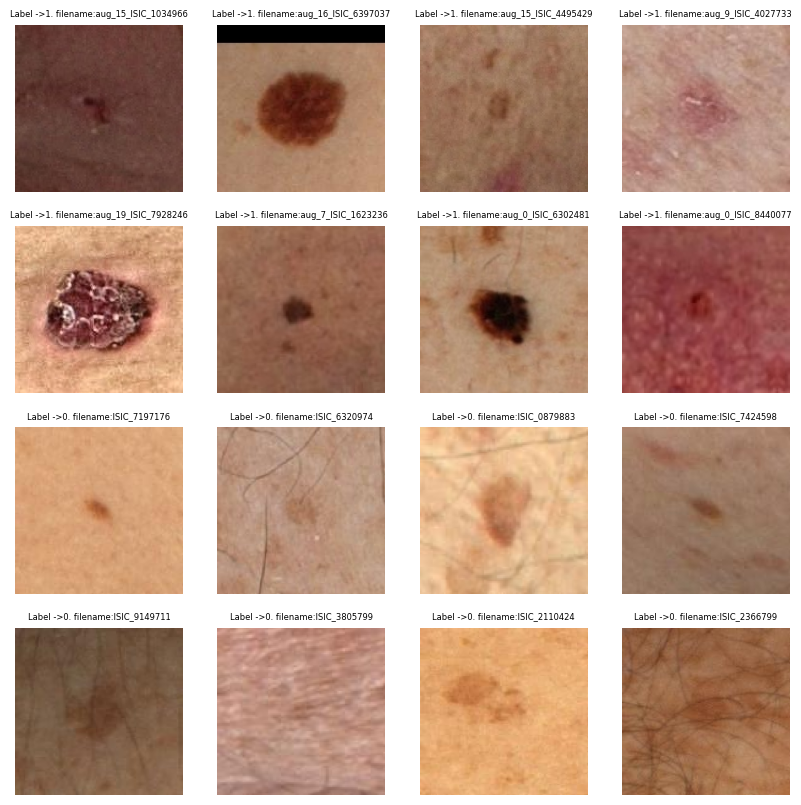

In [6]:
fig , axis = plt.subplots(nrows= 4 , ncols = 4 ,figsize=(10,10))

for ax , im , target in zip(axis.flatten(),pos_img_file+neg_img_file,[1]*8+[0]*8):
    img = Image.open('augment_pos/'+f'{im}.jpg')
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Label ->{target}. filename:{im}',fontsize= 6)


## Data Pre-Processing ⚖️

In [7]:
image_paths = list(train_file['isic_id'])
image_labels = list(train_file['target'])


In [8]:
print(image_labels[:5])
image_paths[:5]

[0, 0, 0, 0, 0]


['ISIC_7931446',
 'ISIC_1968391',
 'ISIC_0251481',
 'ISIC_9678329',
 'ISIC_5942580']

In [9]:
def load_and_preprocess_image(im_path, label):
    im_path = tf.strings.join(['augment_pos/', im_path, '.jpg'], separator='')
    image = tf.io.read_file(im_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [120, 120])
    image = image / 255.0
    return image, label

# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))

# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=len(image_paths), seed=42)

# Define the split ratio
validation_split = 0.2
dataset_size = len(image_paths)
validation_size = int(validation_split * dataset_size)
train_size = dataset_size - validation_size

# Split the dataset into training and validation sets
train_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size)


In [10]:
# Map the preprocessing function to both datasets
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch the datasets
batch_size = 5
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


In [12]:
len(train_dataset)

2516

## Building  Model 🧠 
### Using VGG16

In [11]:
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D,Flatten , Input, GlobalMaxPooling2D
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential

from tensorflow import keras
from tensorflow.keras.models import load_model



### Base of VGG16

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16
conv_base = VGG16(
    weights='imagenet',
    input_shape= (120,120,3),
    include_top= False
)

In [13]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 30, 128)       0     

In [14]:
conv_base.trainable = True

In [15]:
for layer in conv_base.layers:
    print(layer.name,layer.trainable)

input_1 True
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [16]:
for layer in conv_base.layers[:-5]:
    layer.trainable = False

In [17]:
for layer in conv_base.layers:
    print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [18]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 30, 128)       0     

In [19]:
inputs = Input(shape= (120,120,3)),
x = conv_base(inputs)

x = Flatten()(x)
x = Dense(64,activation = 'relu')(x)
x = layers.Normalization()(x)
x = Dense(128,activation = 'relu')(x)
x = layers.Normalization()(x)

x = layers.Dropout(0.5)(x)
outputs =  Dense(1,activation = 'sigmoid')(x)


model = Model(inputs,outputs)



In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 64)                294976    
                                                                 
 normalization (Normalizatio  (None, 64)               129       
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                             

In [21]:
model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.RMSprop(learning_rate=(1e-5)),metrics=['acc'])


In [22]:
history = model.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs = 10,
                    validation_steps = 20)

Epoch 1/10
2516/2516 [==============================] - 38s 14ms/step - loss: 0.4792 - acc: 0.7673 - val_loss: 0.4290 - val_acc: 0.8200
Epoch 2/10
2516/2516 [==============================] - 56s 22ms/step - loss: 0.3397 - acc: 0.8595 - val_loss: 0.2967 - val_acc: 0.8900
Epoch 3/10
2516/2516 [==============================] - 75s 30ms/step - loss: 0.2694 - acc: 0.8968 - val_loss: 0.2529 - val_acc: 0.8800
Epoch 4/10
2516/2516 [==============================] - 68s 27ms/step - loss: 0.2207 - acc: 0.9173 - val_loss: 0.1388 - val_acc: 0.9500
Epoch 5/10
2516/2516 [==============================] - 78s 31ms/step - loss: 0.1717 - acc: 0.9361 - val_loss: 0.0865 - val_acc: 0.9600
Epoch 6/10
2516/2516 [==============================] - 73s 29ms/step - loss: 0.1517 - acc: 0.9486 - val_loss: 0.0653 - val_acc: 0.9900
Epoch 7/10
2516/2516 [==============================] - 76s 30ms/step - loss: 0.1222 - acc: 0.9596 - val_loss: 0.0556 - val_acc: 0.9700
Epoch 8/10
2516/2516 [==========================

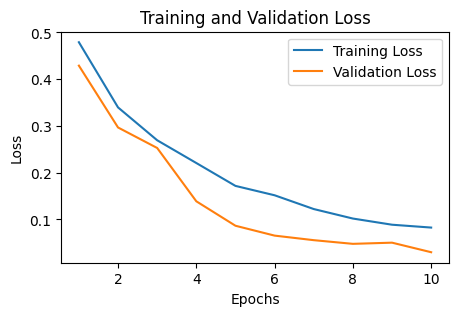

In [23]:

# Extract accuracy and validation accuracy
accuracy = history.history['loss']
val_accuracy = history.history['val_loss']

# Extract number of epochs
epochs = range(1, len(accuracy) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(5, 3))
plt.plot(epochs, accuracy, label='Training Loss')
plt.plot(epochs, val_accuracy, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


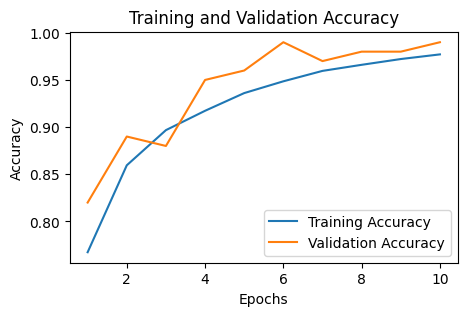

In [24]:
# Extract accuracy and validation accuracy
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

# Extract number of epochs
epochs = range(1, len(accuracy) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(5, 3))
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [25]:
ta = history.history['acc'][-1] * 100
va = history.history['val_acc'][-1] * 100
print(f"Training Accuracy is {ta:.3f}%")
print(f'Validation Accuracy is {va:.3f}%')

Training Accuracy is 97.710%
Validation Accuracy is 99.000%


In [26]:
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
import cv2
import io

# Load the HDF5 file
file_path = 'test-image.hdf5'  # Replace with your HDF5 file path
image_ids = []
predictions = []
images = []

# Function to preprocess images
def preprocess_image(image):
    img_resized = cv2.resize(image, (120, 120))
    img_resized = img_resized.astype('float32') / 255.0
    return img_resized

with h5py.File(file_path, 'r') as hdf:
    # Get the number of test images
    num_test_images = len(hdf.keys())
    
    # Set batch size based on the number of test images
    if num_test_images <= 3:
        batch_size = 3
    else:
        batch_size = 150
    
    # Access each dataset and process the data
    for key in hdf.keys():
        binary_data = hdf[key][...]
        image_ids.append(key)
        
        # Convert binary data to image
        image = Image.open(io.BytesIO(binary_data))
        image = np.array(image)  # Convert PIL Image to numpy array
        preprocessed_image = preprocess_image(image)
        images.append(preprocessed_image)
        
        # If the batch size is reached, make predictions
        if len(images) == batch_size:
            images_np = np.array(images)
            batch_predictions = model.predict(images_np)
            predictions.extend([f'{pred[0]:.6f}' for pred in batch_predictions])
            images = []  # Reset the list for the next batch

    # Process remaining images if any
    if images:
        images_np = np.array(images)
        batch_predictions = model.predict(images_np)
        predictions.extend([f'{pred[0]:.6f}' for pred in batch_predictions])

# Print predictions
for image_id, prediction in zip(image_ids, predictions):
    print(f"Prediction for image {image_id}: {prediction}")


1/1 [==============================] - 1s 797ms/step
Prediction for image ISIC_0015657: 0.005803
Prediction for image ISIC_0015729: 0.000016
Prediction for image ISIC_0015740: 0.000000
